# Model Comparisons

In [1]:
# General imports
import os
import sys
import glob
from pathlib import Path

# Custom Functions
sys.path.append(os.path.abspath('../Notebooks/Utilities')) 
import cust_utilities as utils

# Maths, Pandas etc
import math
import numpy as np
import pandas as pd
import scipy as sci

# Plots
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
# Get all the model evaluation run resuls and combine into a single df
#

data_folder_path = utils.get_folder_path('Model Comparisons')
file_name_pattern = '**/models_results_df**.pkl'
data_files = glob.glob(str(Path(data_folder_path) / file_name_pattern), recursive=True)

df_list = []
for next_file in data_files:
    df = pd.read_pickle(next_file, compression='zip')
    df_list.append(df)
models_evaluations_df = pd.concat(df_list, ignore_index=True)


In [3]:
# Explore the structure of the combined dataframe
print("Dataframe shape:", models_evaluations_df.shape)
print("\nColumns:", models_evaluations_df.columns.tolist())
print("\nModel names:", models_evaluations_df['model_name'].unique() if 'model_name' in models_evaluations_df.columns else "No model_name column")
print("\nFirst few rows:")
display(models_evaluations_df.head())

Dataframe shape: (9, 16)

Columns: ['study', 'training_source_data_run', 'training_results_run', 'search_features_detail', 'search_features_selection', 'CV_search_time', 'CV_best_parameters', 'features_detail', 'features_selection', 'model_name', 'prediction_time', 'mcc', 'recall', 'precision', 'f1_score', 'specificity']

Model names: ['RandomForest_v1' 'LogisticRegression_v1' 'MLPClassifier_v1']

First few rows:


,study,training_source_data_run,training_results_run,search_features_detail,search_features_selection,CV_search_time,CV_best_parameters,features_detail,features_selection,model_name,prediction_time,mcc,recall,precision,f1_score,specificity
0,IOWA_Rest,1b_EEG_Features_Results_Run_20250801_full_run,(2_Feature_Selection_Training_Run_20250812_sea...,"([region],)","([[cf, pw, bw]],)",7.889680,"{'classifier__criterion': 'entropy', 'classifi...",region,"[cf, pw, bw]",RandomForest_v1,0.053513,0.438086,1.000000,0.703704,0.826087,0.272727
1,IOWA_Rest,1b_EEG_Features_Results_Run_20250801_full_run,(2_Feature_Selection_Training_Run_20250812_sea...,"([region],)","([[cf, pw, bw]],)",4.764382,"{'classifier__C': 10, 'classifier__class_weigh...",region,"[cf, pw, bw]",LogisticRegression_v1,0.081201,0.234413,0.842105,0.695652,0.761905,0.363636
2,IOWA_Rest,1b_EEG_Features_Results_Run_20250801_full_run,(2_Feature_Selection_Training_Run_20250812_sea...,"([region],)","([[cf, pw, bw]],)",4.492693,"{'classifier__activation': 'tanh', 'classifier...",region,"[cf, pw, bw]",MLPClassifier_v1,0.026388,0.323268,0.842105,0.727273,0.780488,0.454545
3,IOWA_Rest,1b_EEG_Features_Results_Run_20250801_full_run,(2_Feature_Selection_Training_Run_20250812_sea...,"([channel],)","([[cf, pw, bw]],)",9.475886,"{'classifier__criterion': 'entropy', 'classifi...",channel,"[cf, pw, bw]",RandomForest_v1,0.062812,0.569378,0.842105,0.842105,0.842105,0.727273
4,IOWA_Rest,1b_EEG_Features_Results_Run_20250801_full_run,(2_Feature_Selection_Training_Run_20250812_sea...,"([channel],)","([[cf, pw, bw]],)",68.521576,"{'classifier__C': 1, 'classifier__class_weight...",channel,"[cf, pw, bw]",LogisticRegression_v1,0.012745,0.295790,0.578947,0.785714,0.666667,0.727273


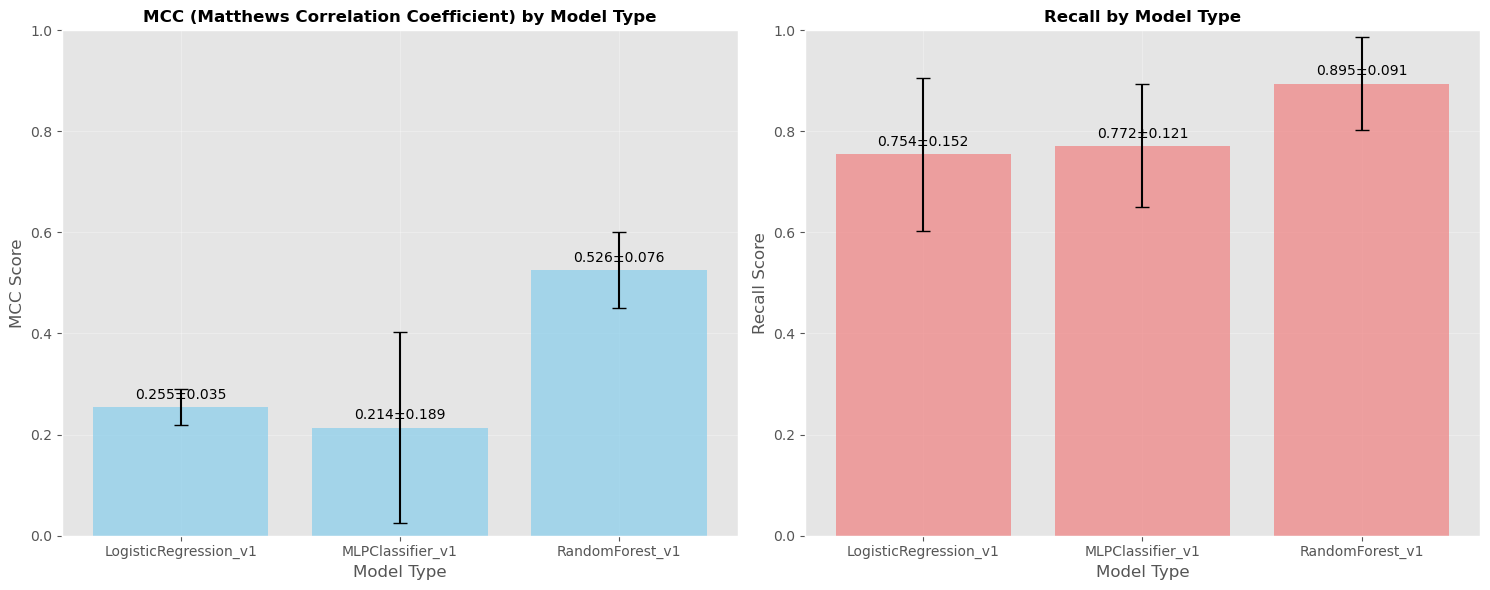


Summary Statistics by Model Type:


,mcc_mean,mcc_std,recall_mean,recall_std
model_name,,,,
LogisticRegression_v1,0.2549,0.0354,0.7544,0.1519
MLPClassifier_v1,0.2139,0.1894,0.7719,0.1215
RandomForest_v1,0.5256,0.0758,0.8947,0.0912


In [4]:
# Create bar plots for MCC and Recall by model type
#

# Check if required columns exist
required_cols = ['mcc', 'recall', 'model_name']
missing_cols = [col for col in required_cols if col not in models_evaluations_df.columns]

if missing_cols:
    print(f"Missing columns: {missing_cols}")
    print("Available columns:", models_evaluations_df.columns.tolist())
else:
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Group by model type and calculate mean values
    grouped_stats = models_evaluations_df.groupby('model_name').agg({
        'mcc': ['mean', 'std'],
        'recall': ['mean', 'std']
    }).round(4)
    
    # Flatten column names
    grouped_stats.columns = ['_'.join(col).strip() for col in grouped_stats.columns.values]
    
    # Plot 1: MCC by model type
    model_types = grouped_stats.index
    mcc_means = grouped_stats['mcc_mean']
    mcc_stds = grouped_stats['mcc_std']
    
    bars1 = ax1.bar(model_types, mcc_means, yerr=mcc_stds, capsize=5, alpha=0.7, color='skyblue')
    ax1.set_title('MCC (Matthews Correlation Coefficient) by Model Type', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Model Type')
    ax1.set_ylabel('MCC Score')
    ax1.set_ylim([0, 1])
    ax1.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, mean_val, std_val in zip(bars1, mcc_means, mcc_stds):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{mean_val:.3f}±{std_val:.3f}',
                ha='center', va='bottom', fontsize=10)
    
    # Plot 2: Recall by model type
    recall_means = grouped_stats['recall_mean']
    recall_stds = grouped_stats['recall_std']
    
    bars2 = ax2.bar(model_types, recall_means, yerr=recall_stds, capsize=5, alpha=0.7, color='lightcoral')
    ax2.set_title('Recall by Model Type', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Model Type')
    ax2.set_ylabel('Recall Score')
    ax2.set_ylim([0, 1])
    ax2.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, mean_val, std_val in zip(bars2, recall_means, recall_stds):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{mean_val:.3f}±{std_val:.3f}',
                ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # Display summary statistics table
    print("\nSummary Statistics by Model Type:")
    display(grouped_stats)

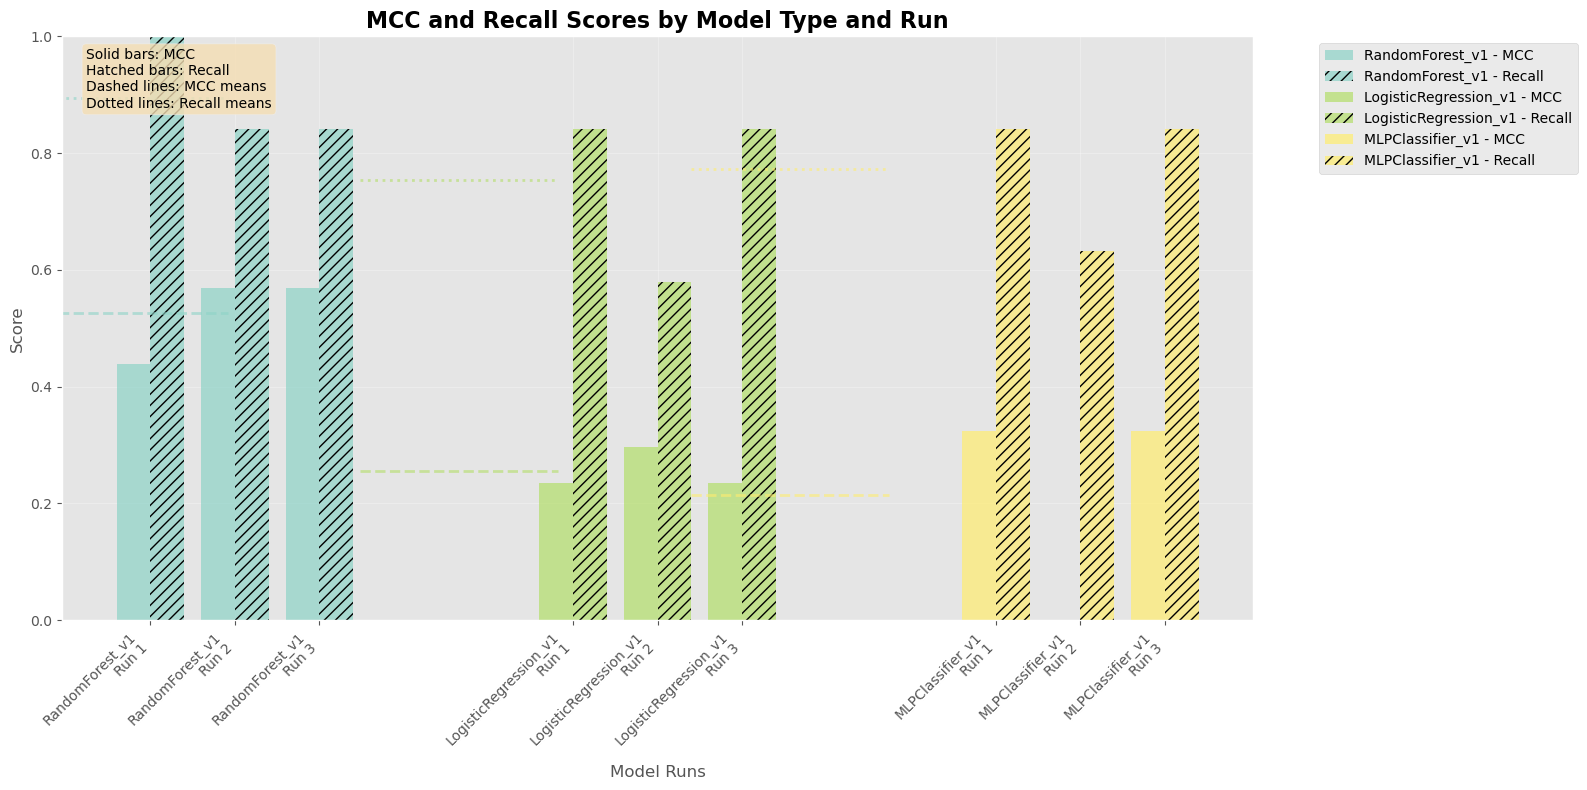

In [5]:
# Alternative visualization: Show MCC and Recall side by side for each model
#

if not missing_cols:
    # Create a single plot with MCC and Recall side by side
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    
    # Get unique model types
    model_types = models_evaluations_df['model_name'].unique()
    colors = plt.cm.Set3(np.linspace(0, 1, len(model_types)))
    
    x_pos = 0
    x_labels = []
    x_positions = []
    bar_width = 0.4
    
    for i, model_type in enumerate(model_types):
        model_data = models_evaluations_df[models_evaluations_df['model_name'] == model_type]
        mcc_values = model_data['mcc'].values
        recall_values = model_data['recall'].values
        
        # Create x positions for this model's runs
        x_range = np.arange(x_pos, x_pos + len(mcc_values))
        
        # Plot MCC and Recall bars side by side
        mcc_bars = ax.bar(x_range - bar_width/2, mcc_values, bar_width, 
                         alpha=0.7, color=colors[i], label=f'{model_type} - MCC')
        recall_bars = ax.bar(x_range + bar_width/2, recall_values, bar_width, 
                           alpha=0.7, color=colors[i], hatch='///', label=f'{model_type} - Recall')
        
        # Add mean lines for MCC and Recall
        mean_mcc = mcc_values.mean()
        mean_recall = recall_values.mean()
        
        # MCC mean line
        ax.axhline(y=mean_mcc, xmin=(x_pos-0.5)/(len(models_evaluations_df)*2), 
                  xmax=(x_pos+len(mcc_values)-0.5)/(len(models_evaluations_df)*2), 
                  color=colors[i], linestyle='--', linewidth=2, alpha=0.6)
        
        # Recall mean line (slightly offset)
        ax.axhline(y=mean_recall, xmin=(x_pos-0.5)/(len(models_evaluations_df)*2), 
                  xmax=(x_pos+len(recall_values)-0.5)/(len(models_evaluations_df)*2), 
                  color=colors[i], linestyle=':', linewidth=2, alpha=0.6)
        
        # Store positions for labels
        x_labels.extend([f'{model_type}\nRun {j+1}' for j in range(len(mcc_values))])
        x_positions.extend(x_range)
        x_pos += len(mcc_values) + 2  # Add gap between model types
    
    ax.set_title('MCC and Recall Scores by Model Type and Run', fontsize=16, fontweight='bold')
    ax.set_ylabel('Score', fontsize=12)
    ax.set_xlabel('Model Runs', fontsize=12)
    ax.set_ylim([0, 1])
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)
    ax.set_xticks(x_positions)
    ax.set_xticklabels(x_labels, rotation=45, ha='right')
    
    # Add a text box with legend explanation
    ax.text(0.02, 0.98, 'Solid bars: MCC\nHatched bars: Recall\nDashed lines: MCC means\nDotted lines: Recall means', 
            transform=ax.transAxes, fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    plt.show()